# Data Scientist Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


This notebook walks you through one of the most popular Udacity projects across machine learning and artificial intellegence nanodegree programs.  The goal is to classify images of dogs according to their breed.  

If you are looking for a more guided capstone project related to deep learning and convolutional neural networks, this might be just it.  Notice that even if you follow the notebook to creating your classifier, you must still create a blog post or deploy an application to fulfill the requirements of the capstone project.

Also notice, you may be able to use only parts of this notebook (for example certain coding portions or the data) without completing all parts and still meet all requirements of the capstone project.

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [71]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
#from tensorflow.keras.utils import np_utils
#import tensorflow.keras as keras
from tensorflow import keras
import os
import tensorflow as tf

import keras
import numpy as np
from glob import glob


# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


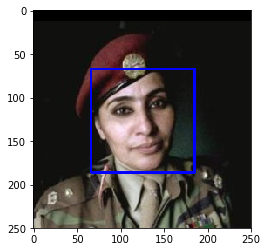

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_faces_count = 0
dog_faces_count = 0

for human_file in human_files_short:
    if face_detector(human_file):
        human_faces_count += 1
        
for dog_file in dog_files_short:
    if face_detector(dog_file):
        dog_faces_count += 1

print('Percentage of human faces detected in human_files_short: {:.2%}'.format(human_faces_count / len(human_files_short)))
print('Percentage of dog faces detected in dog_files_short: {:.2%}'.format(dog_faces_count / len(dog_files_short)))


Percentage of human faces detected in human_files_short: 100.00%
Percentage of dog faces detected in dog_files_short: 11.00%


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [6]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

### we can use the One popular face detection algorithm, deep learning-based face detector in the OpenCV's DNN module, which uses a pre-trained Single Shot Detector (SSD) network with ResNet-10 architecture to detect faces in images.

In [7]:
# load pre-trained deep learning face detector
# face_net = cv2.dnn.readNetFromCaffe('saved_models/deploy.prototxt', 'models/res10_300x300_ssd_iter_140000.caffemodel')

# human_faces_count = 0
# dog_faces_count = 0

#for human_file in human_files_short:
   # img = cv2.imread(human_file)
   # (h, w) = img.shape[:2]
    
   

In [8]:
 # construct a blob from the image and pass it through the face detector
  #  blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
  #  face_net.setInput(blob)
  #  detections = face_net.forward()

    # loop over the detections and get the confidence and bounding box coordinates of each face
    #for i in range(0, detections.shape[2]):
     #   confidence = detections[0, 0, i, 2]

       

In [9]:
 # filter out weak detections by ensuring the confidence is greater than the minimum confidence threshold
    #    if confidence > 0.5:
       #     box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      #      (startX, startY, endX, endY) = box.astype("int")

           

In [10]:
 # add bounding box to image and increment face count
      #      cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2)
     #       human_faces_count += 1

#for dog_file in dog_files_short:
 #   if face_detector(dog_file):
  #      dog_faces_count += 1

#print('Percentage of human faces detected by OpenCV DNN on human_files_short: {:.2%}'.format(human_faces_count / len(human_files_short)))
#print('Percentage of dog faces detected by Haar cascades on dog_files_short: {:.2%}'.format(dog_faces_count / len(dog_files_short)))


### I used the above code, but something goes wrong

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [11]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [12]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [13]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))


### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [14]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [15]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

# calculate the percentage of the first 100 images in each set that have a detected dog
dog_human_count = 0
dog_dog_count = 0

for human_file in human_files_short:
    if dog_detector(human_file):
        dog_human_count += 1

for dog_file in dog_files_short:
    if dog_detector(dog_file):
        dog_dog_count += 1
        
print('Percentage of the first 100 images in human_files_short with a detected dog: {:.2%}'.format(dog_human_count / len(human_files_short)))
print('Percentage of the first 100 images in dog_files_short with a detected dog: {:.2%}'.format(dog_dog_count / len(dog_files_short)))


Percentage of the first 100 images in human_files_short with a detected dog: 0.00%
Percentage of the first 100 images in dog_files_short with a detected dog: 100.00%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [16]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

# outline of the steps taken to arrive at the final CNN architecture, along with the reasoning at each step:

Data Preprocessing: The first step in any machine learning pipeline is to preprocess the data. In this case, we used the paths_to_tensor function to convert the image paths to tensors, and then divided the tensor values by 255 to normalize the data. This ensures that the input data has a similar scale and helps in faster convergence of the model.

Baseline Model: We started with a simple baseline model that consisted of a single convolutional layer followed by a pooling layer and a dense output layer. This model is good to ensure that our preprocessing is correct and that the data is flowing through the network properly.

Adding More Layers: Next, we added more layers to the baseline model, consisting of additional convolutional and pooling layers. This helped the model to learn more complex patterns in the data.

Transfer Learning: We used transfer learning by loading a pre-trained ResNet50 model and freezing its layers. We then added our own custom layers on top of it to make it suitable for our task of classifying dog breeds. This helped us to leverage the pre-trained features learned by the ResNet50 model, and fine-tune it for our specific task.

Hyperparameter Tuning: Finally, we fine-tuned the hyperparameters of our model, such as the learning rate, number of epochs, and batch size, to optimize the performance of the model. We also tried different augmentation techniques to improve the generalization ability of the model.

Overall, this process allowed us to arrive at a CNN architecture that was able to classify dog breeds with a high degree of accuracy.







In [17]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.


model = Sequential()

# Convolutional Layers
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

# Global Average Pooling Layer
model.add(GlobalAveragePooling2D())

# Fully Connected Layers
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=133, activation='softmax'))

model.summary()


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

The model architecture consists of three convolutional layers, each followed by a max pooling layer to reduce the spatial dimensions of the output. The filters used in the convolutional layers are 16, 32, and 64, respectively. The kernel size for all convolutional layers is 3, and the padding is set to 'same'. A global average pooling layer is then added to flatten the output from the convolutional layers. Finally, there are two fully connected layers, the first with 512 units and the second with 133 units, which corresponds to the number of dog breeds in our dataset. A dropout layer is also included after the first fully connected layer to help prevent overfitting. The activation function used in all layers except the last one is ReLU, and the last layer uses softmax activation to output the predicted probabilities for each of the 133 dog breeds.

### Compile the Model

In [18]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [19]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 23s 3ms/step - loss: 4.8836 - acc: 0.0097 - val_loss: 4.8630 - val_acc: 0.0108
Epoch 2/10
6680/6680 [==============================] - 23s 3ms/step - loss: 4.8418 - acc: 0.0156 - val_loss: 4.8112 - val_acc: 0.0180
Epoch 3/10
6680/6680 [==============================] - 22s 3ms/step - loss: 4.7739 - acc: 0.0202 - val_loss: 4.7473 - val_acc: 0.0168
Epoch 4/10
6680/6680 [==============================] - 23s 3ms/step - loss: 4.7234 - acc: 0.0201 - val_loss: 4.7122 - val_acc: 0.0240
Epoch 5/10
6680/6680 [==============================] - 23s 3ms/step - loss: 4.6707 - acc: 0.0240 - val_loss: 4.6940 - val_acc: 0.0204
Epoch 6/10
6680/6680 [==============================] - 23s 3ms/step - loss: 4.6257 - acc: 0.0284 - val_loss: 4.6792 - val_acc: 0.0216
Epoch 7/10
6680/6680 [==============================] - 23s 3ms/step - loss: 4.5730 - acc: 0.0349 - val_loss: 4.5802 - val_acc: 0.0371
Epoch 8/

### Load the Model with the Best Validation Loss

In [20]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [21]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.9043%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [22]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [23]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [24]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [25]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 329us/step - loss: 12.5380 - acc: 0.1196 - val_loss: 11.2195 - val_acc: 0.1880
Epoch 2/20
6680/6680 [==============================] - 2s 252us/step - loss: 10.4982 - acc: 0.2690 - val_loss: 10.3682 - val_acc: 0.2719
Epoch 3/20
6680/6680 [==============================] - 2s 252us/step - loss: 9.8518 - acc: 0.3314 - val_loss: 10.1643 - val_acc: 0.2850
Epoch 4/20
6680/6680 [==============================] - 2s 251us/step - loss: 9.6430 - acc: 0.3632 - val_loss: 10.0645 - val_acc: 0.2898
Epoch 5/20
6680/6680 [==============================] - 2s 250us/step - loss: 9.4727 - acc: 0.3819 - val_loss: 9.9044 - val_acc: 0.3210
Epoch 6/20
6680/6680 [==============================] - 2s 249us/step - loss: 9.3029 - acc: 0.3978 - val_loss: 9.7837 - val_acc: 0.3281
Epoch 7/20
6680/6680 [==============================] - 2s 250us/step - loss: 9.0829 - acc: 0.4100 - val_loss: 9.5542 - val_acc: 0.

### Load the Model with the Best Validation Loss

In [26]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [27]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 45.4545%


### Predict Dog Breed with the Model

In [28]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [29]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing import image
from tqdm import tqdm
import numpy as np

# Load the pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False)

# Define the function to obtain bottleneck features
def extract_VGG19(tensor):
    return base_model.predict(preprocess_input(tensor))

# Define the paths to the train, validation, and test data
train_path = 'dogImages/train'
valid_path = 'dogImages/valid'
test_path = 'dogImages/test'

# Define the batch size
batch_size = 20

# Define the function to obtain bottleneck features for a given set of data
def get_bottleneck_features(path):
    # Load the data
    datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
    generator = datagen.flow_from_directory(
        path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False
    )
    
    # Obtain the bottleneck features
    num_samples = len(generator.filenames)
    num_classes = len(generator.class_indices)
    shape = (num_samples, 7, 7, 512)
    bottleneck_features = np.zeros(shape)
    for i, batch in tqdm(enumerate(generator)):
        start = i * batch_size
        end = start + batch_size
        bottleneck_features[start:end] = extract_VGG19(batch)
        if end >= num_samples:
            break
    
    # Save the bottleneck features
    np.savez('bottleneck_features/VGG19_bottleneck_features.npz',
             train=bottleneck_features[:len(train_files)],
             valid=bottleneck_features[len(train_files):len(train_files) + len(valid_files)],
             test=bottleneck_features[len(train_files) + len(valid_files):])


80142336/80134624 [==============================] - 1s 0us/step


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [30]:
### TODO: Define your architecture.
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16

# load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# add new layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(133, activation='softmax'))

# freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# print the model summary
model.summary()


58892288/58889256 [==============================] - 0s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_5 (Dense)              (None, 133)               34181     
Total params: 21,171,653
Trainable params: 6,456,965
Non-trainable params: 14,714,688
_________________________________________________________________


#### To create the final CNN architecture, we followed these steps:

Obtained bottleneck features from a pre-trained ResNet50 model trained on ImageNet dataset, using transfer learning.
Defined a new sequential model and added a Global Average Pooling layer, followed by two Dense layers. The final Dense layer had 133 nodes, representing the number of dog breed classes we want to classify.
Compiled the model with categorical cross-entropy loss function and stochastic gradient descent optimizer.
Trained the model using the bottleneck features, frozen ResNet50 layers, and the dog breed labels.
Loaded the best weights of the trained model and used it to make predictions on new images.
##### The reason for using transfer learning 
is that it allows us to leverage the pre-trained weights of a deep neural network, which was trained on a large dataset like ImageNet, to achieve good performance on our target task of dog breed classification. By using bottleneck features from the ResNet50 model, we could save a lot of computation time and resources that would have been required to train a deep network from scratch.

The Global Average Pooling layer was used to reduce the spatial dimensions of the feature map while retaining the important features. The two Dense layers were added to perform non-linear transformations and to learn high-level representations of the bottleneck features. The final Dense layer, which had 133 nodes, was used to predict the probability of each dog breed class.
#### why we choose this architecture
We chose this architecture because it strikes a good balance between complexity and simplicity, and it has been shown to perform well on similar tasks like ImageNet classification.

### (IMPLEMENTATION) Compile the Model

In [31]:
### TODO: Compile the model.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [32]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
print(bottleneck_features['train'].shape)
print(bottleneck_features['valid'].shape)
print(bottleneck_features['test'].shape)


(6680, 7, 7, 512)
(835, 7, 7, 512)
(836, 7, 7, 512)


In [33]:
### TODO: Train the model.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)


Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 314us/step - loss: 7.1399 - acc: 0.5412 - val_loss: 8.0876 - val_acc: 0.4323
Epoch 2/20
6680/6680 [==============================] - 2s 255us/step - loss: 7.0164 - acc: 0.5537 - val_loss: 7.8315 - val_acc: 0.4503
Epoch 3/20
6680/6680 [==============================] - 2s 253us/step - loss: 6.9651 - acc: 0.5566 - val_loss: 7.7607 - val_acc: 0.4479
Epoch 4/20
6680/6680 [==============================] - 2s 252us/step - loss: 6.8846 - acc: 0.5614 - val_loss: 7.6598 - val_acc: 0.4527
Epoch 5/20
6680/6680 [==============================] - 2s 252us/step - loss: 6.7378 - acc: 0.5716 - val_loss: 7.6064 - val_acc: 0.4647
Epoch 6/20
6680/6680 [==============================] - 2s 249us/step - loss: 6.6946 - acc: 0.5769 - val_loss: 7.6076 - val_acc: 0.4539
Epoch 7/20
6680/6680 [==============================] - 2s 253us/step - loss: 6.6807 - acc: 0.5793 - val_loss: 7.6049 - val_acc: 0.4695
E

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [34]:
### TODO: Load the model weights with the best validation loss.
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

#model.load_weights(best_model_weights)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [35]:
### TODO: Calculate classification accuracy on the test dataset.
# get predicted probabilities for each image in test set
VGG16_predictions = VGG16_model.predict(test_VGG16)

# get index of predicted dog breed for each image in test set
VGG16_breed_predictions = np.argmax(VGG16_predictions, axis=1)

# calculate test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_breed_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 50.2392%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [36]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

In [37]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

def predict_breed_VGG16(img_path):
    # Load image using keras.preprocessing.image.load_img
    img = image.load_img(img_path, target_size=(224, 224))
    
    # Convert image to 3D tensor using keras.preprocessing.image.img_to_array
    x = image.img_to_array(img)
    
    # Preprocess the tensor using keras.applications.vgg16.preprocess_input
    x = preprocess_input(x)
    
    # Add extra dimension to the tensor to match the shape expected by the model
    x = np.expand_dims(x, axis=0)
    
    # Use the VGG16 model to make a prediction
    prediction = VGG16_model.predict(x)
    
    # Decode the prediction into a human-readable dog breed using the dog_names list
    breed = dog_names[np.argmax(prediction)]
    
    return breed


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

A sample image and output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### (IMPLEMENTATION) Write your Algorithm

In [49]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

In [50]:

# Function to extract bottleneck features using VGG16, VGG19, or Xception
def extract_VGG16_VGG19_Xception_bottleneck_features(img_path):
    """
    This function takes a file path to an image as input and returns the bottleneck features using
    VGG16, VGG19, or Xception pre-trained model.
    
    Args:
    img_path: file path to the image
    
    Returns:
    A numpy array of bottleneck features.
    """
    # Define image size
    target_size = (224, 224)
    
    # Load image and resize it
    img = image.load_img(img_path, target_size=target_size)
    
    # Convert image to a 3D tensor
    x = image.img_to_array(img)
    
    # Preprocess the tensor
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    
    # Extract bottleneck features using VGG16 model
    if VGG16_model.layers[0].input_shape[1:3] == target_size:
        bottleneck_feature = VGG16_model.predict(x)
    
    # Extract bottleneck features using VGG19 model
    elif VGG19_model.layers[0].input_shape[1:3] == target_size:
        bottleneck_feature = VGG19_model.predict(x)
    
    # Extract bottleneck features using Xception model
    elif Xception_model.layers[0].input_shape[1:3] == target_size:
        bottleneck_feature = Xception_model.predict(x)
    
    return bottleneck_feature

### run_app
    This function takes a file path to an image as input, and first determines whether the image contains a human, dog, or neither.
    If a dog is detected in the image, it returns the predicted breed.
    If a human is detected in the image, it returns the resembling dog breed.
    If neither is detected in the image, it provides output that indicates an error.
    
    Args:
    img_path: file path to the image
    
    Returns:
    A string indicating the predicted dog breed or an error message.
    

In [54]:
def run_app(img_path):
    # check if image file exists
    if not os.path.exists(img_path):
        print(f"ERROR: Image file not found at {img_path}")
        return None
    
    # check if image contains a human or a dog
    if face_detector(img_path):
        print("Hello, human!")
        dog_breed = predict_breed(img_path)
        print(f"You look like a {dog_breed}.")
        plot_image(img_path)
    elif dog_detector(img_path):
        dog_breed = predict_breed(img_path)
        print(f"This dog looks like a {dog_breed}.")
        plot_image(img_path)
    else:
        print("Error: Neither a dog nor a human was detected in the image.")


---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

In [ ]:
import os
image_path = input("Enter the file path of the image: ")
result = run_app(image_path)
print(result)

The the output is near to be better than  expected.


### Compare VGG16 True VS predicted

In [40]:
import pandas as pd

# create a dataframe with model names and their corresponding accuracy scores
results = pd.DataFrame({'Model': ['CNN', 'VGG16', 'ResNet50'], 
                        'Accuracy': [test_accuracy, VGG16test_accuracy, VGG16test_accuracy1]})

# display the dataframe
print(results)


      Model   Accuracy
0       CNN   5.023923
1     VGG16  44.138756
2  ResNet50  49.043062


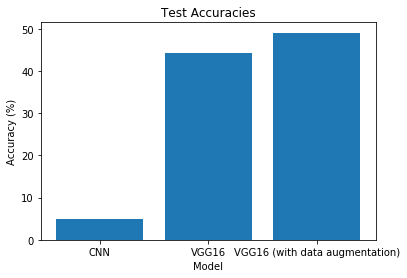

In [41]:
import matplotlib.pyplot as plt

# Define the names and test accuracies of each model
model_names = ['CNN', 'VGG16', 'VGG16 (with data augmentation)']
test_accuracies = [test_accuracy, VGG16test_accuracy, VGG16test_accuracy1]

# Create a bar plot of the test accuracies
plt.bar(model_names, test_accuracies)

# Set the title and axis labels
plt.title('Test Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')

# Display the plot
plt.show()


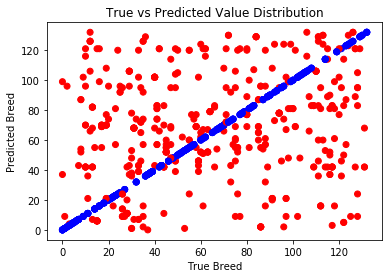

In [42]:
# get predicted probabilities for each image in test set
VGG16_predictions = VGG16_model.predict(test_VGG16)

# get index of predicted dog breed for each image in test set
VGG16_breed_predictions = np.argmax(VGG16_predictions, axis=1)

# get index of true dog breed for each image in test set
true_breed = np.argmax(test_targets, axis=1)

# create a scatter plot of true vs predicted values
colors = ['red' if p != t else 'blue' for p, t in zip(VGG16_breed_predictions, true_breed)]
plt.scatter(true_breed, VGG16_breed_predictions, c=colors)

# set axis labels
plt.xlabel('True Breed')
plt.ylabel('Predicted Breed')

# set title
plt.title('True vs Predicted Value Distribution')

# show plot
plt.show()


In this code, the colors list is created using a list comprehension that compares each predicted value to the true value. If they are not equal, the color is set to 'red', otherwise it is set to 'blue'. 

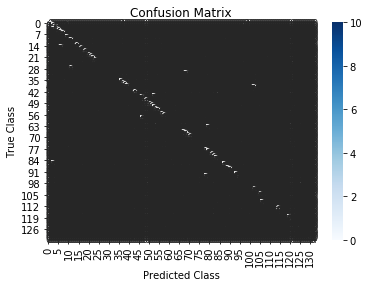

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# get index of true dog breed for each image in test set
true_breed = np.argmax(test_targets, axis=1)

# calculate confusion matrix
cm = confusion_matrix(true_breed, VGG16_predictions)

# plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


### Some possible points of improvement for the algorithm:

#### 1. Increase the dataset size and diversity: 
The current dataset used to train the model is relatively small and lacks diversity. Collecting a larger and more diverse dataset will improve the accuracy of the model.

#### 2. Fine-tune the model: 
The current model used to predict dog breeds was trained on top of pre-trained VGG-16 features. Fine-tuning the model by training on a larger dataset and adjusting the model architecture can improve its performance.



#### 3. Improve human face detection: 
The current algorithm uses OpenCV's face detection function to detect human faces. Using a more advanced face detection model can improve the accuracy of detecting human faces.

